In [29]:
using Random, Gadfly, Optim, Distributions, Distances, LinearAlgebra, ForwardDiff, Cairo

include("../../iGMRF.jl");
include("../../dataGen.jl");
include("../../approxFramework.jl");
include("../../plotting.jl");
include("optim.jl");

In [13]:
# Seed
Random.seed!(400)
# Dimensions de la grille
m₁ = 3;
m₂ = 3;
# Nb total de cellules
m = m₁ * m₂;
# Matrice de structure
κᵤ = 100.0;
F = iGMRF(m₁, m₂, κᵤ);
# Grille cible
grid_target = generateTargetGrid(F);
grid_target[:, :, 1] = grid_target[:, :, 1] .+ 10;
# Génération de données
nobs = 100;
Y = generateData(grid_target, nobs);

In [14]:
res = KLOptim(F, Y)

 * Status: success (objective increased between iterations)

 * Candidate solution
    Final objective value:     -4.017649e+01

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 1.65e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.47e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.68e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.41e-15 ≰ 0.0e+00
    |g(x)|                 = 7.10e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   3  (vs limit Inf)
    Iterations:    25
    f(x) calls:    75
    ∇f(x) calls:   75
    ∇²f(x) calls:  25


## Analyse de l'approximation

### Visuelle

In [15]:
η̂ = Optim.minimizer(res)[1:m];
Σ̂ = diagm(fill(Optim.minimizer(res)[m+1]^2, m));
â = Optim.minimizer(res)[m+2]^2;
b̂ = Optim.minimizer(res)[m+3]^2;

logDensityApprox(x::DenseVector) = logpdf(MvNormal(η̂, Σ̂), x[2:m+1]) + logpdf(Gamma(â, b̂), x[1]);

In [16]:
â

125.26087060642354

In [17]:
b̂

0.041946393187324245

Graphiques LOG

In [18]:
npoints = 10000; # Nombre de points sur lesquels évaluer la pdf
x = range(-10, 10, npoints);

# Mode de la posteriori
mode = findMode(θ -> functionalFormPosterior(θ, F=F, Y=Y), [1, fill(0.0, m)...]);
α = Optim.minimizer(mode);
gap = Optim.minimum(mode);

analysisSpace = zeros(m+1, npoints);
for j = 1:npoints
    analysisSpace[:, j] = [x[j], α[2:end]...];
end

simApprox = vec(mapslices(x -> logDensityApprox(x), analysisSpace, dims=1));
simPosterior = vec(mapslices(x -> densityTarget(x, gap, F=F, Y=Y), analysisSpace, dims=1));

p = plot(
    layer(x=x, y=simApprox, Geom.line, Theme(default_color="red")),
    layer(x=x, y=simPosterior, Geom.line),
    Guide.manual_color_key("Legend", ["Approximation", "Posteriori"], ["red", "deepskyblue"]),
    Theme(background_color="white"),
    Guide.title("Pour epsilon_u")
)

draw(PNG("../../plots/NGDH/v4/log_kappa.png", dpi=300), p)

In [19]:
npoints = 10000; # Nombre de points sur lesquels évaluer la pdf
x = range(-10, 18, npoints);

# Mode de la posteriori
mode = findMode(θ -> functionalFormPosterior(θ, F=F, Y=Y), [1, fill(0.0, m)...]);
α = Optim.minimizer(mode);
gap = Optim.minimum(mode);

analysisSpace = zeros(m+1, npoints);
for j = 1:npoints
    analysisSpace[:, j] = [α[1], x[j], α[3:end]...];
end

simApprox = vec(mapslices(x -> logDensityApprox(x), analysisSpace, dims=1));
simPosterior = vec(mapslices(x -> densityTarget(x, gap, F=F, Y=Y), analysisSpace, dims=1));

p = plot(
    layer(x=x, y=simApprox, Geom.line, Theme(default_color="red")),
    layer(x=x, y=simPosterior, Geom.line),
    Guide.manual_color_key("Legend", ["Approximation", "Posteriori"], ["red", "deepskyblue"]),
    Theme(background_color="white"),
    Guide.title("Pour mu")
)

draw(PNG("../../plots/NGDH/v4/log_mu.png", dpi=300), p)

Approx vs MCMC

In [20]:
include("../../mcmc.jl");

niter = 10000
δ² = 0.2
κᵤ₀ = 10
μ₀ = zeros(m)

θ = gibbs(niter, Y, m₁=m₁, m₂=m₂, δ²=δ², κᵤ₀=κᵤ₀, μ₀=μ₀);

warming_size = Int(0.2 * niter);
θsampling = θ[warming_size:end, :, :];

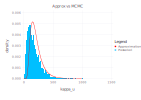

In [28]:
# Pour κᵤ
densityEpsilon(x::Real) = pdf(Gamma(â, b̂), x);
densityKappa(x::Real) = 1/x * densityEpsilon(log(x));
a = 0;
b = 1000;
step = 0.01;

plotApproxVSMCMC(
    densityKappa,
    θsampling.value[:, 1, 1],
    # "../plots/NGDH/v4/approxvsmcmc_kappa.png",
    a=a,
    b=b,
    step=step;
    xLabel="kappa_u",
    yLabel="density",
)

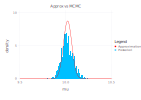

In [27]:
# Pour μ

approxDensity(x::Real) = pdf(Normal(η̂[1], sqrt(Σ̂[1, 1])), x)
a = 9.5;
b = 10.5;
step = .001;

plotApproxVSMCMC(
    approxDensity,
    θsampling.value[:, 2, 1],
    # "../plots/NGDH/v4/approxvsmcmc_mu.png",
    a=a,
    b=b,
    step=step,
    xLabel="mu",
    yLabel="density",
)